In [1]:
pip install torchviz


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


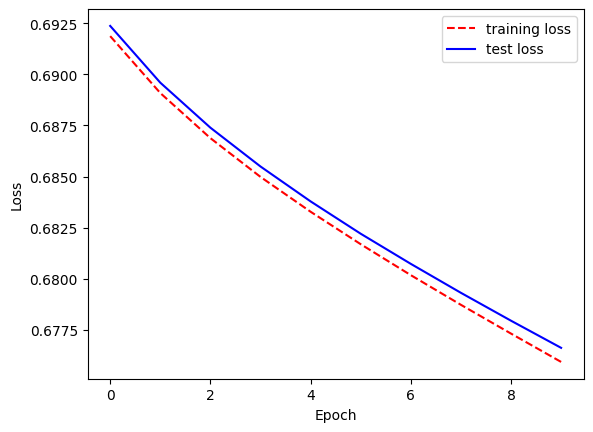

In [3]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop 
from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split 
import numpy as np 
import matplotlib.pyplot as plt 
from torchviz import make_dot

# ===============================
# Dataset
# ===============================
features, target = make_classification(
    n_classes=2, n_features=10, n_samples=1000
)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1
)

x_train = torch.from_numpy(features_train).float()
x_test  = torch.from_numpy(features_test).float()

y_train = torch.from_numpy(target_train).float().view(-1, 1)
y_test  = torch.from_numpy(target_test).float().view(-1, 1)

torch.manual_seed(0)
np.random.seed(0)

# ===============================
# Model
# ===============================
class MySimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequential(x)

network = MySimpleNet()

# ===============================
# Training setup
# ===============================
criterion = nn.BCELoss()
optimizer = RMSprop(
    network.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

dataset = TensorDataset(x_train, y_train)
loader = DataLoader(dataset, batch_size=100, shuffle=True)

epochs = 10
train_losses = []
test_losses = []

# ===============================
# 🔍 torchviz visualization (ONE TIME)
# ===============================
sample_x = x_train[:1]                  # single sample
sample_output = network(sample_x)        # forward pass
dot = make_dot(
    sample_output,
    params=dict(network.named_parameters())
)
dot.render("simple_neural_network", format="png")

# ===============================
# Training loop
# ===============================
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        train_output = network(x_train)
        test_output = network(x_test)
        train_losses.append(criterion(train_output, y_train).item())
        test_losses.append(criterion(test_output, y_test).item())

# ===============================
# Plot
# ===============================
epochs_range = range(epochs)
plt.plot(epochs_range, train_losses, "r--")
plt.plot(epochs_range, test_losses, "b-")
plt.legend(["training loss", "test loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
